# Machine Learning in Python - Project 1

*Sayantan Bal, Samyukta Ramesh, Sayli Patil, Rebecca Joy*

---
# **Setup**
---

In [13]:
# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize']=(8,5)
plt.rcParams['figure.dpi']=80
def set_plot_defaults(axes, title_size=14, label_size=12, legend_size=10, tick_size=10):
    """Removes all borders, sets title, labels, legends font size"""
    for ax in axes:
        [ax.spines[sp].set_visible(False) for ax in axes for sp in ["top", "right"]]
        [ax.spines[sp].set_color("gray") for ax in np.atleast_1d(axes).flatten() for sp in ["left", "bottom"]]
        ax.set_title(ax.get_title(), fontsize=title_size)
        ax.set_xlabel(ax.get_xlabel(), fontsize=label_size)
        ax.set_ylabel(ax.get_ylabel(), fontsize=label_size)

# sklearn modules
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

---
# **1. Introduction** 
---  
Alzheimer’s disease (AD) is a growing global health crisis, driving up healthcare costs and impacting millions of lives. The Alzheimer’s Disease Neuroimaging Initiative (ADNI) gathers extensive clinical, imaging, and genetic data to track cognitive decline from normal aging to Alzheimer’s. This project aims to develop a predictive model to estimate ADAS13 cognitive scores at a 24-month follow-up using baseline data. By leveraging key clinical and neuroimaging features, the model helps pinpoint individuals at high risk of cognitive decline, enabling early interventions and smarter clinical trial recruitment. 

The study begins with a baseline linear regression model, followed by the ridge and lasso regression models. The ridge regression model was ultimately selected as it captured essential predictors of cognitive decline while maintaining explainability and validation. This approach ensures that the results can support early intervention strategies and precision medicine in Alzheimer’s research, providing a robust framework for identifying individuals at risk of cognitive deterioration. 

Among the most significant risk factors for cognitive decline identified in this study are baseline cognitive impairment, hippocampal atrophy, and the presence of the APOE4 allele. Baseline cognitive impairment, measured through initial ADAS13 scores, serves as a strong predictor of future decline, while hippocampal atrophy reflects neurodegenerative progression in Alzheimer's disease. The APOE4 allele, a well-established genetic risk factor, further amplifies susceptibility to cognitive deterioration, reinforcing its critical role in Alzheimer’s pathology. 

---
# **2. Exploratory Data Analysis and Feature Engineering**
---

## 2.1. Data Understanding
The dataset used in this study is a simplified version of the Alzheimer's Disease Neuroimaging Initiative (ADNI) dataset, designed to predict cognitive decline over a 24-month period.

In [14]:
# Load the dataset
file_path = "adnidata.csv"  # Ensure this file is uploaded to the working directory
df = pd.read_csv(file_path, index_col=0)
df.head()

,RID,ADAS13.bl,ADAS13.m24,AGE,DX.bl,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
1,3,31.00,37.67,81.3,AD,Male,18,Not Hisp/Latino,White,Married,1.0,84599.0,5319.0,1129834.0,1791.0,15506.0,18422.0,1.920691e+06
2,5,14.67,11.00,73.7,CN,Male,16,Not Hisp/Latino,White,Married,0.0,34062.0,7075.0,1116633.0,4433.0,24788.0,21614.0,1.640766e+06
3,6,25.67,22.67,80.4,LMCI,Female,13,Not Hisp/Latino,White,Married,0.0,39826.0,5348.0,927510.0,2277.0,17963.0,17802.0,1.485834e+06
4,7,40.33,47.00,75.4,AD,Male,10,Hisp/Latino,More than one,Married,1.0,25704.0,6729.0,875798.0,2050.0,12063.0,15374.0,1.353519e+06
5,10,24.33,30.33,73.9,AD,Female,12,Not Hisp/Latino,White,Married,1.0,26820.0,5485.0,1033542.0,2676.0,16761.0,19741.0,1.471184e+06


The dataset consists of a mix of continuous, categorical, and ordinal variables, each potentially contributing uniquely to cognitive decline prediction. 

Detailed below are the features and their potential impact on cognitive decline<sup><a href="#references">1</a></sup>.

| Column Name   | Feature Description  | Dtype | Variable Type | Non-null Count | Expected Impact on Cognitive Decline |
|--------------|---------------------|---------|----|-------------|------------------------|
| **RID** | Person identifier | int64 | Discrete | 1038 | Unique person identifier, unrelated to cognitive decline|
| **ADAS13.bl** | Baseline ADAS-Cog 13 score | float64 | Continuous | 1038 | Higher baseline scores strongly predict future decline |
| **ADAS13.m24** | ADAS-Cog 13 score at 24-month follow-up visit | float64 | Continuous | 1038 | Cognitive decline scores to be predicted for the model |
| **AGE** | Age at baseline | float64 | Continuous | 1038 | Older individuals are more likely to experience cognitive decline |
| **DX.bl** | Diagnosis at baseline (CN, EMCI, LMCI, AD)* | object | Ordinal | 1038 | Diagnoses at baseline visit in increasing order of severity |
| **PTGENDER** | Gender (Male/Female) | object | Categorical | 1038 | No strong direct effect, but may influence risk factors |
| **PTEDUCAT** | Years of education | int64 | Continuous | 1038 | Higher education may provide cognitive resilience, slowing decline |
| **PTETHCAT** | Ethnicity (Not Hispanic/Hispanic/Unknown) | object | Categorical | 1038 | May capture demographic risk factors, but impact is unclear |
| **PTRACCAT** | Race (White, Black, Asian, etc.) | object | Categorical | 1038 | May reflect socioeconomic and genetic risk factors |
| **PTMARRY** | Marital status at baseline | object | Categorical | 1038 | Social engagement may be a protective factor against decline |
| **APOE4** | APOE genotype (0, 1, or 2 copies of e4 allele) | float64 | Categorical | 1033 | Strong genetic risk factor; individuals with APOE4 more likely to decline |
| **Ventricles** | Volume of the ventricles (mm³) | float64 | Continuous | 891 | Larger ventricular volume suggests greater brain atrophy and higher cognitive decline risk |
| **Hippocampus** | Volume of the hippocampus (mm³) | float64 | Continuous | 891 | Smaller hippocampus is linked to memory loss and greater decline |
| **WholeBrain** | Volume of the whole brain (mm³) | float64 | Continuous | 890 | Reduced whole brain volume indicates overall brain atrophy and AD progression |
| **Entorhinal** | Volume of the entorhinal cortex (mm³) | float64 | Continuous | 891 | Affected early in AD; smaller volume may indicate faster progression |
| **Fusiform** | Volume of the fusiform gyrus (mm³) | float64 | Continuous | 891 | Plays a role in object recognition and memory, with reduced volume linked to cognitive decline |
| **MidTemp** | Volume of the middle temporal lobe (mm³) | float64 | Continuous | 891 | Important for memory and cognition, atrophy indicates higher decline risk |
| **ICV** | Intracranial volume (mm³) | float64 | Continuous | 1030 | Used as a reference measure; may not directly impact cognitive decline |

*Cognitively normal (CN), early mild cognitive impairment (ECMI), late cognitive impairment (LCMI), and Alzheimer’s disease (AD), in increasing order of severity 

## 2.2. Data Visualizations
Next, we're interested in the distribution of the data and the quantitative effects of the features on the response variable. We will look at the following plots - 
1. Distribution of the response variable ADAS13.m24

2. Plots of diagnoses by gender, ethnicity, race and marital status

3. Pairplots of the numerical features against each other and the response variable

**1. <u>Distribution of the Response Variable ADAS13.m24**</u>

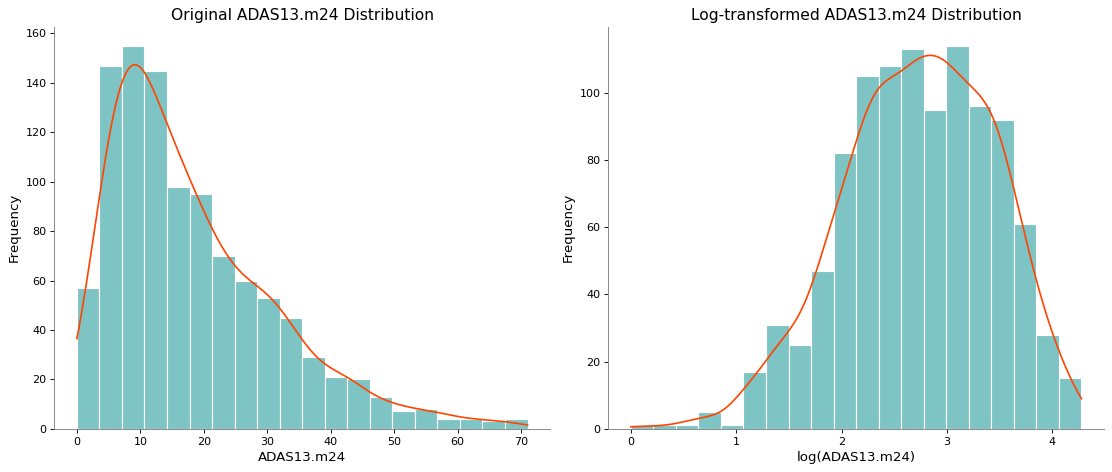

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Original histogram
sns.histplot(df["ADAS13.m24"], bins=20, color="#008B8B", edgecolor="white", kde=True,
             ax=ax[0]).set(title="Original ADAS13.m24 Distribution", xlabel="ADAS13.m24", ylabel="Frequency")

# Log-transformed histogram
sns.histplot(np.log1p(df["ADAS13.m24"]), bins=20, color="#008B8B", edgecolor="white", kde=True, 
             ax=ax[1]).set(title="Log-transformed ADAS13.m24 Distribution", xlabel="log(ADAS13.m24)", ylabel="Frequency")

[ax.lines[0].set_color("#FF4500") for ax in ax if ax.lines] # Setting KDE line colour
set_plot_defaults(ax.flatten())  # Apply defaults
plt.tight_layout() # Adjust layout and show plots
plt.show()

The distribution of ADAS13.m24 exhibits a unimodal and right-skewed pattern, indicating that the majority of values are concentrated towards the lower end, with a long tail extending towards higher scores. The median score is 15, suggesting that at least half of the individuals in the dataset have a cognitive impairment score at or below this value.

To meet the assumptions of linear regression, a log transformation is applied to normalize the distribution. This transformation effectively reduces skewness, making the data more suitable for predictive modeling. Additionally, the log-transformed distribution reveals greater variability, highlighting a wider spread of values across different levels of cognitive impairment. 

**2. <u>Plots of Diagnoses by Gender, Ethnicity, Race & Marital Status</u>**

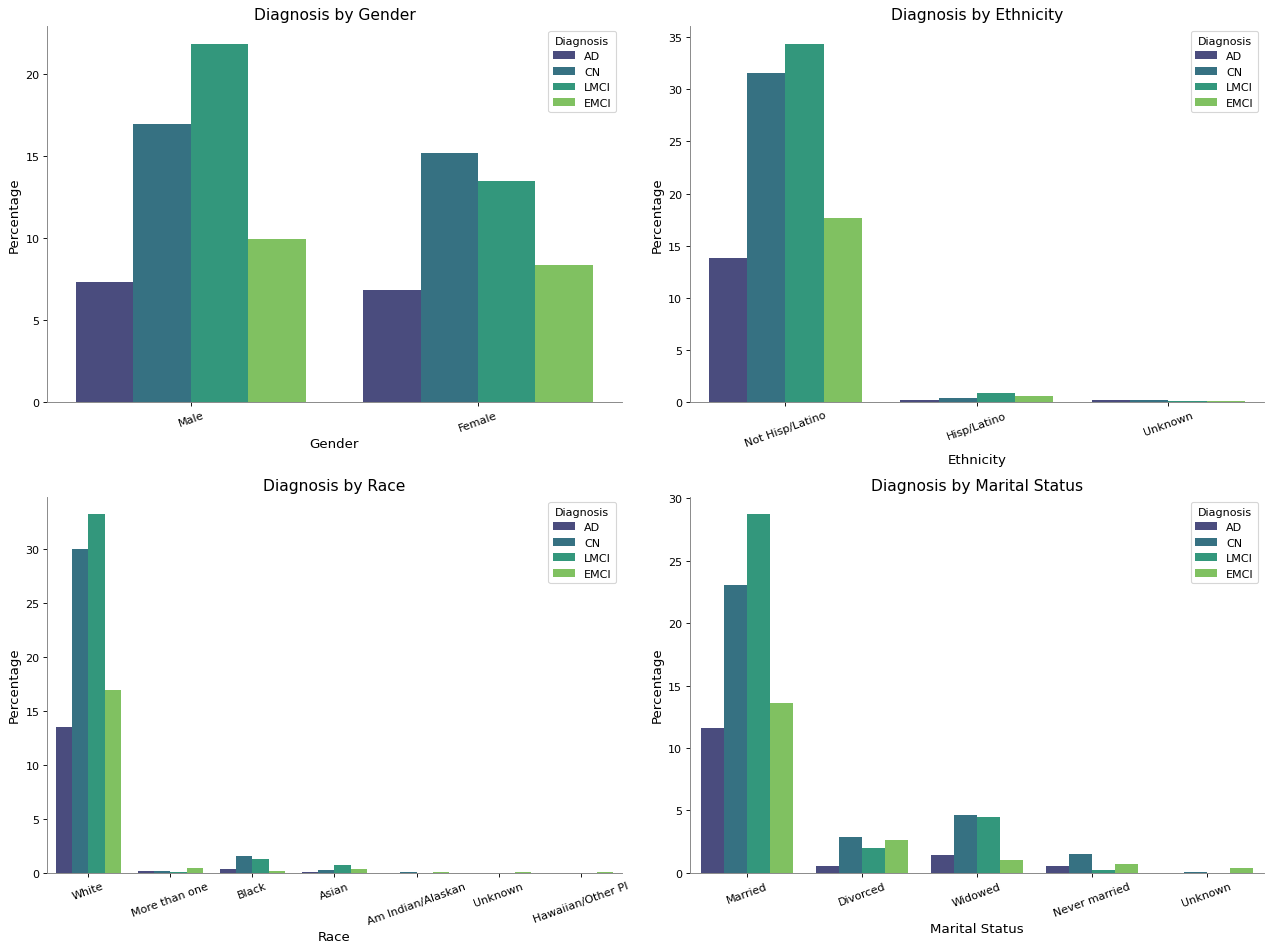

In [16]:
# Define the selected categorical variables (excluding APOE4)
categorical_features = ["PTGENDER", "PTETHCAT", "PTRACCAT", "PTMARRY"]
cat_features = ["Gender", "Ethnicity", "Race", "Marital Status"] # Names for plotting

fig, ax = plt.subplots(2, 2, figsize=(16, 12))  # Adjust figure size
ax = ax.flatten()  # Flatten the axes array for easy iteration

for i, cat in enumerate(categorical_features): # Plot each categorical variable
    sns.countplot(data=df, x=cat,stat="percent", hue="DX.bl", palette="viridis", ax=ax[i]).set(title=f"Diagnosis by {cat_features[i]}",
        xlabel=cat_features[i], ylabel="Percentage")
    ax[i].tick_params(axis='x', rotation=20) 
    ax[i].legend(title="Diagnosis")
    
set_plot_defaults(ax.flatten())  # Apply defaults
fig.tight_layout()
plt.show()

The graphs above illustrate the distribution of diagnoses across key demographic factors, including gender, ethnicity, race, and marital status.

- **Gender:**
The overall distribution of data for men and women appears to be balanced. However, Late Mild Cognitive Impairment (LMCI) is observed at a higher rate in men compared to women. In contrast, Cognitively Normal (CN) diagnoses are more frequent in women than in men for individuals aged 55 and older. This pattern suggests that men over the age of 55 may have a higher likelihood of being diagnosed with more advanced cognitive impairment, including conditions closer to Alzheimer's disease.

- **Ethnicity:**
The dataset primarily consists of non-Hispanic/Latino individuals, with very few observations from other ethnic groups. This suggests that data collection efforts have disproportionately focused on this population, potentially introducing bias. The limited representation of other ethnicities may lead to misinterpretations of cognitive decline trends if ethnicity is considered a key factor in analysis.

- **Race:**
The majority of available data pertains to white individuals, with limited representation of other racial groups. This imbalance suggests a sampling bias that may skew findings when assessing the relationship between race and cognitive impairment. As a result, any conclusions drawn about racial differences in cognitive decline should be interpreted with caution, as they may not accurately reflect the experiences of underrepresented racial groups.

- **Marital Status:**
Similar to race and ethnicity, the dataset shows a disproportionate representation of married individuals, while other marital status categories are significantly underrepresented. This may lead to misleading conclusions when analyzing the relationship between marital status and cognitive decline, as findings may not be generalizable across different groups.

The dataset exhibits potential sampling bias, particularly concerning ethnicity, race, and marital status. The overrepresentation of specific demographic groups may lead to misinterpretations of cognitive decline trends among underrepresented populations.

**3. <u>Pairplots of the numerical features against each other and the response variable</u>**  

To facilitate the visualization of pairplots for all numerical covariates, the total brain volume will be computed as the sum of individual brain region volumes. Although there is currently no conclusive evidence of strong relationships among these regions, they will be retained for separate, detailed analyses.

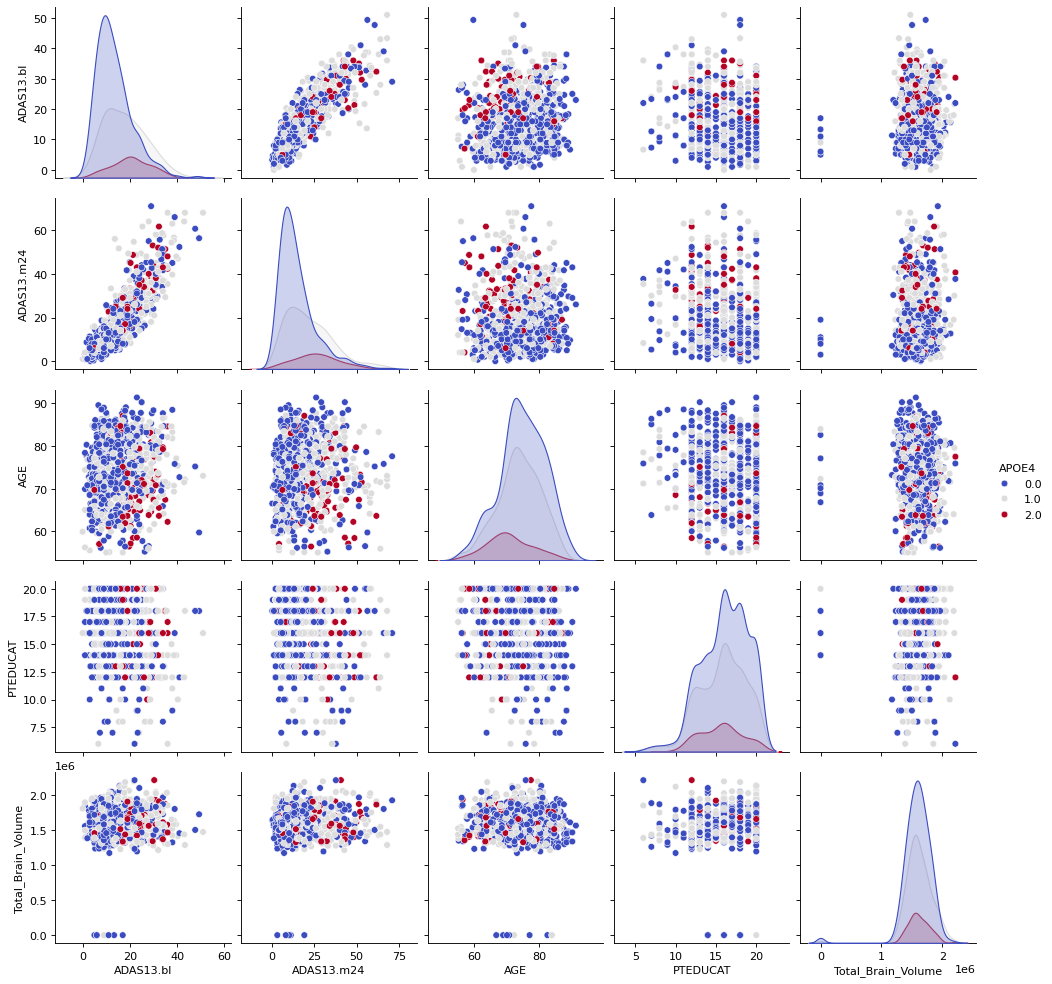

In [17]:
# Calculate Total Brain Volume
brain_volume_features = ["Hippocampus", "Ventricles", "Entorhinal", "Fusiform", "MidTemp", "ICV"]
df["Total_Brain_Volume"] = df[brain_volume_features].sum(axis=1, skipna=True)

# Pairplot for Key Features (Including Total Brain Volume)
selected_features = ["ADAS13.bl", "ADAS13.m24", "AGE", "PTEDUCAT", "Total_Brain_Volume", "APOE4"]
sns.pairplot(df[selected_features],hue="APOE4",palette="coolwarm")
plt.show()
df = df.drop('Total_Brain_Volume', axis=1)

The analysis reveals a strong correlation between ADAS13.bl and ADAS13.m24, indicating that baseline cognitive scores are closely related to follow-up assessments. However, there is no evident collinearity among the other features, suggesting that each variable might contribute independently to the prediction of cognitive decline.

Age is identified as a significant factor influencing cognitive decline. Individuals over the age of 55 exhibit a greater likelihood of increased ADAS13.m24 scores, reinforcing the association between aging and cognitive impairment. Additionally, the presence of APOE4 alleles is linked to higher ADAS13.m24 scores, but this effect is predominantly observed within the 55+ age group.

Education level also demonstrates a notable relationship with cognitive health. Individuals with a higher number of years of education tend to exhibit better cognitive function, with a greater proportion classified as cognitively normal. This supports the notion that education may serve as a protective factor against cognitive decline.

## 2.3. Data Preprocessing Steps

Now, we have a fair idea of the data, the distribution of the response variable and it's relationship with the features. To endure the dataset is clean and suitable for modelling, several cleaning and preprocessing activities are performed. This is to prevent data leakage and ensure that all exploratory analysis, feature selection, and modelling decisions are made only using the training set, allowing for an unbiased evaluation of model performance. After dropping the columns and splitting the data, the remaining preprocessing steps were applied using a ColumnTransformer.
 
- The column "RID" is dropped, since it is a person identifier, and is not related to the response variable
- The dataset is split into training (80%) and testing (20%) sets
- Missing numerical and catergorical values are handled using median imputation and mode, respectively
- Feature encoding, categorical variables are transformed using one-hot encoding, ordinal variables ('DX.bl') using ordinal encoder
- Log transformation is applied to all numerical features and the response to address the skewness
- Numerical features are also scaled; standardization is applied using Z-score normalization

In [18]:
X = df.drop(columns=["ADAS13.m24", "RID"], errors='ignore') # Remove unnecessary columns, and setting up the features
y = np.log1p(df['ADAS13.m24']) # Setting up the response variable

# Splitting Data into the sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---
# **3. Model Fitting and Tuning**
---

## 3.1. Data Preprocessing Execution
The dataset comprises categorical, ordinal, and numerical features, which are preprocessed using a ColumnTransformer pipeline before being used for model training. The goal is to assess the predictive performance of three regression models: Linear Regression, Ridge Regression, and Lasso Regression.

In [19]:
# Define feature categories
categorical_features = ["PTGENDER", "PTETHCAT", "PTRACCAT", "PTMARRY", "APOE4"]
ordinal_features = ["DX.bl"]
numerical_features = ["ADAS13.bl", "AGE", "Ventricles", "Hippocampus", "WholeBrain",
    "Entorhinal", "Fusiform", "MidTemp", "ICV", "PTEDUCAT"]

# Preprocessing pipeline with log transformation
log_transformer = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("log_transform", log_transformer),
        ("scaler", StandardScaler())]), numerical_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values
        ('encoder', OneHotEncoder(drop=['Female', 'Unknown', 'Unknown', 'Unknown', 0.0], handle_unknown='ignore'))  # One-hot encode categorical features
    ]), categorical_features),
    ('ord', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing ordinal values
            ('encoder', OrdinalEncoder(categories=[['CN', 'EMCI', 'LMCI', 'AD']]))  # Ordinal encoding
        ]), ordinal_features)
        ], remainder='passthrough')

In [20]:
# Transform features
X_train_transformed = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out())
X_test_transformed = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())

## 3.2. Model Fitting

We will fit a linear regression model, due to the observable linear nature of the features with the ADAS Cog-13 score at the 24-month folow up. 
The following metrics will be used to evaluate the model performance:

- Mean square error: which measures the average squared difference between actual and predicted values. Lower MSE would indicate a better fit, however, MSE is sensitive to outliers.
- R<sup>2</sup>: measures how well the independent variables explain the variability in the dependent variable.

In [21]:
# ==========================
# 1. Baseline Model: Linear Regression
# ==========================

lin_reg = LinearRegression()
lin_reg.fit(X_train_transformed, y_train)

# Predictions
y_pred_lin = lin_reg.predict(X_test_transformed)

# Model Evaluation
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)
var_lin = np.var(y_test - y_pred_lin)

# Clean feature names while ensuring no feature is missed
#feature_names = [name.replace("cat_"name, name).replace("num_", "").replace("ord_", "").strip() for name in X_train_transformed.columns]
feature_names = [name.replace("cat_", "").replace("num_", "").replace("ord_", "").replace("_", " ").strip() for name in X_train_transformed.columns]

The linear regression model yields an R<sup>2</sup> value of 0.78345, indicating a strong fit. However, this may suggest potential overfitting. To ensure the model generalizes well and avoids overfitting, we will explore Ridge and Lasso regression. These regularization techniques help mitigate overfitting by adding a penalty to the model coefficients, thereby improving stability and predictive performance.

### Performance Improvement by Regularization Techniques : Ridge vs Lasso
Ridge regression (L2 regularization) penalizes large coefficients by adding the squared magnitude of coefficients to the loss function, effectively reducing their impact while preserving all features. Lasso regression (L1 regularization) not only shrinks coefficients but can also set some to zero, performing automatic feature selection. Both methods help enhance model stability, with Ridge being preferable for handling multicollinearity and Lasso for simplifying models by selecting key predictors.

In [22]:
# ==========================
# 2. Ridge Regression
# ==========================

ridge_params = {"alpha": np.logspace(-3, 3, 10)}
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring="neg_mean_squared_error")
ridge_cv.fit(X_train_transformed, y_train)

ridge_best = ridge_cv.best_estimator_

y_pred_ridge = ridge_best.predict(X_test_transformed) # Predictions

mse_ridge = mean_squared_error(y_test, y_pred_ridge) # Model Evaluation
r2_ridge = r2_score(y_test, y_pred_ridge)
var_ridge = np.var(y_test - y_pred_ridge)

# ==========================
# 3. Lasso Regression
# ==========================

lasso_params = {"alpha": np.logspace(-3, 3, 10)}
lasso = Lasso(max_iter=10000)
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5, scoring="neg_mean_squared_error")
lasso_cv.fit(X_train_transformed, y_train)

lasso_best = lasso_cv.best_estimator_

y_pred_lasso = lasso_best.predict(X_test_transformed) # Predictions

mse_lasso = mean_squared_error(y_test, y_pred_lasso) # Model Evaluation
r2_lasso = r2_score(y_test, y_pred_lasso)
var_lasso = np.var(y_test - y_pred_lasso)

Feature Importance: Ridge vs. Lasso
- **Ridge Regression** retained all features, which is advantageous for understanding how various factors contribute to cognitive decline.
- **Lasso Regression** performed feature selection by setting some coefficients to zero, which helped in identifying the most significant predictors.

In [23]:
print("      Performance Metrics on Test Data\n")

model_results = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression", "Lasso Regression"],
    "MSE": [mse_lin, mse_ridge, mse_lasso],
    "R² Score": [r2_lin, r2_ridge, r2_lasso],
    "Best Alpha": ['NA', ridge_cv.best_params_['alpha'], lasso_cv.best_params_['alpha']],
    "Model Variance": [var_lin, var_ridge, var_lasso]})

print(model_results)

      Performance Metrics on Test Data

               Model       MSE  R² Score Best Alpha  Model Variance
0  Linear Regression  0.103164  0.783450         NA        0.103041
1   Ridge Regression  0.101421  0.787108       10.0        0.101234
2   Lasso Regression  0.103417  0.782919   0.004642        0.103107


To improve the model's robustness and reduce the risk of overfitting, **ridge regression** was chosen as the final model, as it outperformed the **linear** and **lasso** regression models, as seen in their MSE and R<sup>2</sup> values in the table above. This method is particularly effective in controlling the magnitude of coefficients while retaining all relevant predictive features. The L2 penalty helps mitigate the influence of outliers and high variance, making the model more resilient in complex datasets.

# Model Tuning

### Hyperparameter Optimization
A key aspect of tuning Ridge Regression involved optimizing the **alpha ($\alpha$) parameter**, which controls the degree of regularization. Higher values of $\alpha$ result in greater shrinkage of coefficients, leading to a more constrained model, whereas lower values keep the model closer to the baseline regression (ordinary least squares). The optimal $\alpha$ was identified through **grid search cross-validation (GridSearchCV)** over a logarithmic range from **10<sup>-3</sup> to 10<sup>3</sup>**, ensuring a balance between underfitting and overfitting. The best $\alpha$ value was found to be **10.0**.

### Regularization Effect
By applying Ridge regularization, we observed a slight reduction in model variance while maintaining predictive power, with the highest R<sup>2</sup>. This regularization ensured that the model performed well on the training data, improving its **generalization ability** and making it a more reliable choice for predicting **cognitive scores**.

### Model Coefficients


These findings underscore the **importance of early detection and continuous monitoring** in individuals at high risk of cognitive decline, particularly those with **structural brain changes or genetic predispositions**.

In [24]:
# ==========================
# 5. Print Coefficients in DataFrame
# ==========================

from IPython.display import display

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficients": ridge_best.coef_})
#coef_df = coef_df.T
display(coef_df.T.style.hide(axis="columns"))

Feature,ADAS13.bl,AGE,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,PTEDUCAT,PTGENDER Male,PTETHCAT Hisp/Latino,PTETHCAT Not Hisp/Latino,PTRACCAT Am Indian/Alaskan,PTRACCAT Asian,PTRACCAT Black,PTRACCAT Hawaiian/Other PI,PTRACCAT More than one,PTRACCAT White,PTMARRY Divorced,PTMARRY Married,PTMARRY Never married,PTMARRY Widowed,APOE4 1.0,APOE4 2.0,DX.bl
Coefficients,0.447655,-0.013800,0.011936,-0.021314,0.016877,-0.002858,-0.040050,-0.069708,0.047117,-0.020981,0.001369,0.063487,0.004091,-0.050497,0.028199,0.002460,-0.039580,0.013878,0.019052,-0.069523,-0.035184,0.029024,0.065928,0.048765,0.087390,0.132751


- ADAS13.bl emerges as the most influential predictor, though Ridge regression slightly reduces its magnitude.
- The features Fusiform, AGE, Ventricles, Entorhinal, MidTemp, ICV, PTEDUCAT, and APOE4 experience minimal penalization, highlighting their strong impact on the response variable.
- Ridge regression significantly diminishes the influence of ethnicity and race, suggesting these features were weaker predictors or that the linear model may have overemphasized them.
- For the remaining features, ridge either reverses their impact or substantially shrinks their coefficients, indicating they may be less significant than previously suggested by the linear model, where their coefficients remained relatively large.

From a model performance perspective, Ridge regression effectively adapts to the data while applying sufficient regularization. Notably, although the response variable appears highly dependent on ADAS13.bl, the model remains robust even when this feature is removed, suggesting a well-balanced contribution from other predictors.

# **4. Discussion & Conclusions**

## Model Implications & Feature Significance
 
The models highlight several **key risk factors** for cognitive decline. The most influential features in predicting **ADAS13.m24** include:
 
**1. Baseline Cognitive Score (ADAS13.bl)**  
Individuals with **higher baseline impairment** are more likely to experience **significant cognitive decline** over time. This score remains a **strong predictor** of future cognitive function and is a key indicator in assessing **Alzheimer’s disease progression**.
 
**2. Brain Volume Measures**  
Changes in **brain structure** play a crucial role in cognitive decline. Findings indicate that **larger ventricular, fusiform, ICV, entorhinal** and **middle temporal lobe volumes** correlate with **greater impairment**, reinforcing the **importance of neuroimaging** in risk assessment.
 
**3. Age**  
Aging is a natural factor influencing cognitive function. **Older individuals** tend to exhibit **higher levels of cognitive impairment**, emphasizing the need for **early interventions and monitoring** in aging populations.
 
**4. APOE4 Genotype**  
Genetic predisposition plays a role in cognitive decline:
- **Individuals carrying one or two copies of the APOE4 allele** are at an **increased risk of faster cognitive decline**.
- This genetic marker is strongly linked to **Alzheimer’s disease progression**, making it a valuable target for **personalized treatment approaches**.
 
**5. Baseline Diagnosis (DX.bl)**  
The severity of cognitive decline varies based on initial diagnosis:
- Those diagnosed with **Alzheimer’s disease at baseline** exhibit the **greatest cognitive decline**.
- Individuals with **mild cognitive impairment (MCI)** show **significant deterioration**, suggesting that **early interventions may slow disease progression**.

## Recommendations for Early Interventions
Based on the findings, the following recommendations are proposed:
 
1. **Targeted Monitoring**: Individuals with high ADAS13 scores, brain atrophy, or APOE4 genotype should undergo regular cognitive assessments for early detection and intervention.
2. **Genetic & Biomarker Screening**: APOE4 screening and neuroimaging can aid in risk assessment and disease tracking.
3. **Personalized Medicine**: APOE4 carriers may benefit from targeted drug trials, lifestyle interventions, and tailored treatment regimens.
4. **Lifestyle Modifications**: Cognitive engagement, physical activity, and cardiovascular health can help delay cognitive decline, especially in individuals with mild cognitive impairment (MCI).
5. **AI in Healthcare**: AI-driven predictive models can enhance early detection, risk prediction, and personalized treatment strategies. 

## Limitations
 
While **Ridge Regression** performed well, some limitations must be considered:  

**1. Feature Interpretability:** Ridge regression retains **retains all features**, making interpretation more complex

**2. Scaling for New Data:** While the model fits the current data well, it may be sensitive to new observations or additional features, potentially leading to instability. Continuous monitoring is essential, especially when incorporating new data or handling potential outliers, to ensure sustained model performance.

**3. Unobserved Variables:** The dataset does not include **lifestyle habits, diet, or medication usage**, all of which may influence cognitive decline. Future models should incorporate additional variables to enhance predictive power.
 
**4. Generalizability:** The model is trained on a specific dataset, which may limit its applicability to broader populations. Certain features, such as AGE, exhibit selection bias, while demographic features like race, ethnicity, and marital status are heavily skewed toward a single category, leading to imbalanced representation. This lack of diversity in the data affects model interpretation and reliability. External validation across diverse demographics is crucial before real-world deployment.

## Areas for Improvement
**1. Feature Selection & Dimensionality Reduction:** Integrating Principal Component Analysis (PCA) can help identify the most influential features that explain variability, particularly when introducing new predictors. This approach ensures that only the most relevant information is retained, improving model efficiency.

**2. Adaptive Scaling & Continuous Monitoring:** Given the model’s potential sensitivity to new data, real-time monitoring and recalibration are essential to maintain stability. In addition to regularizing coefficients, applying robust scaling techniques to input distributions can mitigate feature drift and prevent performance deterioration over time.

**3. Bias Mitigation & Generalizability:** To offset the demographic inbalance in the data set, targeted data collection, resampling techniques, and external validation across diverse populations are necessary to improve fairness and enhance the model’s applicability in real-world settings.

# Generative AI statement

In this project, Generative AI was used for generating explanations for error messages and debugging, providing hints or suggestions to improve code, and enhance visualizations and the quality of the report.

# References
1. [Alzheimers Disease Neuroimaging Initiative (ADNI) - MRI Preprocessing](https://adni.loni.usc.edu/data-samples/adni-data/neuroimaging/mri/mri-pre-processing/)
 
2. [Feature Importance in Alzheimers Disease Progression](https://pmc.ncbi.nlm.nih.gov/articles/PMC11034932/)

In [25]:
!jupyter nbconvert --to pdf [Final]project1.ipynb

zsh:1: no matches found: [Final]project1.ipynb
